# School dataset

In order to reproduce and improve the data regarding the Human Development Index, we need to categorize USs' states by their level of instruction. 
One indicator which may turn to be significant to categorize the level of instruction in each country is probably the average cost of private schools (both for high school and elementary school).
We found an article on the website https://www.privateschoolreview.com/tuition-stats/private-school-cost-by-state which keeps track of these two statistics, and in order to convert the data present on their website to usable data (pandas DataFrame) we need to scrape the information from the web.

In [1]:
from requests import get
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup

We now focus on extracting data from the website  https://www.privateschoolreview.com/tuition-stats/private-school-cost-by-state

## Names of states
First we download the list of names of the US states from the link. 
https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json

In [2]:
states_json = pd.read_json('Data/states.json')  # Get the json with state names
states = []

for row in states_json['data']:
    states.append(row['State'])   # Add the names to a list.
    
states_df = pd.DataFrame({"State": states})   # Create a DataFrame with the list of states.
states_df.head()

,State
0,Alabama
1,Alaska
2,Arizona
3,Arkansas
4,California


## Format of the webpage

We noticed that the webpage has the following format: states are listed in a table, and in every row there are 4 tds:
- td[0] is a link with the name of the state
- td[1] is the average tuition
- td[2] is the average high school tuition
- td[3] is the average elementary school tuition

In [3]:
# Site to scrape
privateschoolreview = ' https://www.privateschoolreview.com/tuition-stats/private-school-cost-by-state'

# Get the page and parse it with BeautifulSoup
school_page = get(privateschoolreview)
school_page = BeautifulSoup(school_page.text,'html.parser')

# Find the table in the page (it is the table which contains the information we need)
table = school_page.find('table', class_='tuition-list')

# Get rows in the table
rows = table.find_all('tr', class_='table_row row_click')

tuition_fees = []

for row in rows:
    # Skip empty Rows (page is not well formatted)
    if type(row) != 'NoneType':
        # Information are stored in table data cells.
        tds = row.find_all('td')
        
        state = tds[0].find('a').text
        high_school_fee = tds[2].text
        elementary_school_fee = tds[3].text
        
        # Create a new object with the right information and add it to the list.
        tuition = {
            'State': state,
            'High_School_Fee': high_school_fee,
            'Elementary_School_Fee': elementary_school_fee
        }
        tuition_fees.append(tuition)

# Create a DataFrame
tuition_fees_df = pd.DataFrame(tuition_fees)
tuition_fees_df.head()

,State,High_School_Fee,Elementary_School_Fee
0,Alaska,"$6,118","$7,544"
1,Alabama,"$7,633","$6,388"
2,Arkansas,"$6,580","$4,724"
3,Arizona,"$17,339","$6,300"
4,California,"$19,235","$11,360"


# Analysis of the data
Before proceeding further, we first check whether all states are listed in the new dataframe.

In [4]:
# We merge the DataFrame with the state DataFrame created at the beginning
# We do a left join (on the states DataFrame) so that states missing in tuition_fees_df
# are still going to be present (but with null value)
states_merged = states_df.merge(tuition_fees_df, how='left', right_on='State', left_on='State')
# Select states which have null values for High_School_Fee (meaning that the left join)
# couldn't find the tuition fees values for that state.
absent_states = states_merged[~states_merged.High_School_Fee.notnull()]
absent_states

,State,High_School_Fee,Elementary_School_Fee
8,District of Columbia,NaN,NaN
34,North Dakota,NaN,NaN
41,South Dakota,NaN,NaN
50,Wyoming,NaN,NaN


We can clearly see that the dataset is not complete, as four states lack the high school and the elementary school average fee.

Let't try to get this data out from the same website: analyzing deeper the website, we discovered that the same data is present on a state basis under the link https://www.privateschoolreview.com/tuition-stats/state-name

The names of the states must be turned into lowercase, substituting whitespaces with character dash ("-").

In [5]:
# We turn the state name into lowercase, and substitute whitespaces with dashes
lowercased_dashed_states = absent_states.State.apply(lambda x: '-'.join(x.lower().split(' ')))
real_names = absent_states.State 

# We create a dataframe with column for the real name  and the lowercased and dashed name
lowercased_dashed_states_df = pd.DataFrame({
    'lowercased_dashed_name': lowercased_dashed_states,
    'real_name': real_names
})

lowercased_dashed_states_df

,lowercased_dashed_name,real_name
8,district-of-columbia,District of Columbia
34,north-dakota,North Dakota
41,south-dakota,South Dakota
50,wyoming,Wyoming


### Then we can scrape the new webpages to look for the missing information:
- The information we are looking for lies in the `div` with `class='school_notes_overview'`
- It is the second `<li>` of an unordered list `<ul>` of `class='highlights_row'` 
- The first price (regex `re'\$\d+(,\d+)?'`) is the elementary school price, and the second price is the high school tuition fee. 

In [6]:
base_url_single_state = 'https://www.privateschoolreview.com/tuition-stats/'

for index, row in lowercased_dashed_states_df.iterrows():
    real_name = row['real_name']
    state_lowercased_dashed = row['lowercased_dashed_name']
    
    # First get the page and scrape it with BeautifulSoup
    tuition_per_state = get(base_url_single_state + state_lowercased_dashed)
    html_page_tuition_per_state = BeautifulSoup(tuition_per_state.text,'html.parser')
    
    # find the correct div with class school_notes_overview, and select the <ul> element
    school_notes_overview = html_page_tuition_per_state.find('div', class_='school_notes_overview').find('ul')
    
    # get second <li> of class 'highlights_row'
    second_li = school_notes_overview.find_all('li', class_='highlights_row')[1].text
    print("{}: {}".format(real_name,second_li))
    
    # apply the regex re'\$\d+' (it should find both the elementary fee and the high school fee)
    occurrences = re.findall('\$\d+,\d+', second_li)
    elementary_fee, high_school_fee = occurrences[0], occurrences[1]
    
    new_fee = {
        'State': real_name,
        'High_School_Fee': high_school_fee,
        'Elementary_School_Fee': elementary_fee
    }
    # Update the tuition_fees_df with the newly scraped information
    tuition_fees_df.loc[index] = new_fee
    
    

District of Columbia: The private elementary school average is $19,084 per year and the private high school average is $27,337 per year.
North Dakota: The private elementary school average is $2,550 per year and the private high school average is $9,100 per year.
South Dakota: The private elementary school average is $3,029 per year and the private high school average is $6,717 per year.
Wyoming: The private elementary school average is $3,417 per year and the private high school average is $10,575 per year.


### Here we can see that the missing values has been correctly substituted

In [7]:
absent_states.index
tuition_fees_df.loc[absent_states.index]

,State,High_School_Fee,Elementary_School_Fee
8,District of Columbia,"$27,337","$19,084"
34,North Dakota,"$9,100","$2,550"
41,South Dakota,"$6,717","$3,029"
50,Wyoming,"$10,575","$3,417"


## Now we have all the data
We can start converting the input into a more usable format.
For instance, the tuition fee is a string containing the characters `$` followed by a number, with the thousand digits separated by a comma.
We can therefore cast this number to an integer number.

In [8]:
# Remove '$' and ',' and convert the resulting number into an integer (for both Elementary School and High School)
high_school_fees = tuition_fees_df.High_School_Fee.apply(lambda x: int("".join(x.split('$')[1].split(','))) )
elementary_school_fees = tuition_fees_df.Elementary_School_Fee.apply(lambda x: int("".join(x.split('$')[1].split(','))) )

tuition_fees_df.High_School_Fee = high_school_fees
tuition_fees_df.Elementary_School_Fee = elementary_school_fees

tuition_fees_df.head()

,State,High_School_Fee,Elementary_School_Fee
0,Alaska,6118,7544
1,Alabama,7633,6388
2,Arkansas,6580,4724
3,Arizona,17339,6300
4,California,19235,11360


## Save pickle
Before doing any kind of Analysis, we save the DataFrame in a pickle file so that it can be merged with the other datasets in the notebook `Milestone2.ipynb`.

In [9]:
tuition_fees_df.to_pickle('Pickles/tuition_fees.pickle')

# Analysis and description of dataset:
Now that the data is cleaned and complete, we can start developing some statistics over it.
For instance, we may want to plot a chart to show if there are any outliers (fees incredibly high or low).

<BarContainer object of 48 artists>

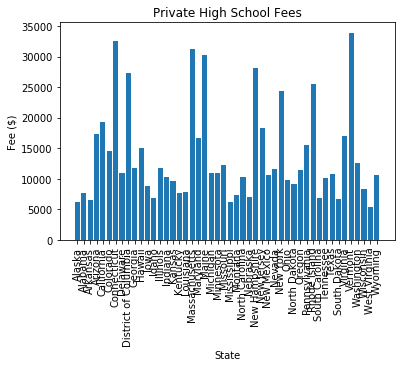

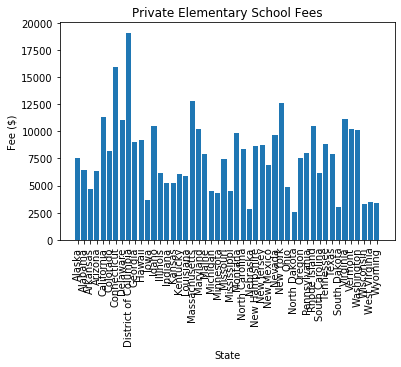

In [10]:
# Figure 1 (High School)
plt.figure(0)
plt.bar(tuition_fees_df.State, tuition_fees_df.High_School_Fee)
plt.title("Private High School Fees")
plt.xlabel("State")
plt.ylabel("Fee ($)")
plt.xticks(rotation=90)   # Rotate x labels (otherwise all state names become unreadable)

# Figure 2 (Elementary School)
plt.figure(1)
plt.title("Private Elementary School Fees")
plt.ylabel("Fee ($)")
plt.xticks(rotation=90)   # Rotate x labels (otherwise all state names become unreadable)
plt.xlabel("State")
plt.bar(tuition_fees_df.State, tuition_fees_df.Elementary_School_Fee)

We can notice that there are no unreasonable outliers values, although some countries show much higher values than others.

### Further analysis and expectations
We may now wonder whether the relation among the cost of high school and elementary is somehow linear: we may assume, in fact, that no matter the level of instruction, if in one state schools are more expensive, than it must be true for both elementary and high schools. We can double check this assumption by computing the correlation ratio among the two variables, and plotting a scatterplot with fees for high school and elementary school on the two axis.

In [11]:
corr = tuition_fees_df.corr()   # Get the correlation values
corr

,High_School_Fee,Elementary_School_Fee
High_School_Fee,1.000000,0.680728
Elementary_School_Fee,0.680728,1.000000


(0, 19910.709856630823)

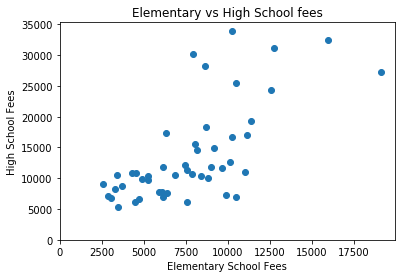

In [12]:
plt.scatter(tuition_fees_df.Elementary_School_Fee, tuition_fees_df.High_School_Fee)
plt.title("Elementary vs High School fees")
plt.xlabel("Elementary School Fees")
plt.ylabel("High School Fees")
plt.ylim(ymin=0)
plt.xlim(xmin=0)

We can see that our assumption is only partially true, in fact not only the correlation ratio is not particulary high (=~0.7), but even the plot doesn't show a precise linear relation among the two variables (although, it has to be said, there are no states where the cost of Elementary School and High School are at the opposite extremes).

## Analysis
To conclude, what we may assume is that the cost of private schools can be a good candidate for the educational part of the Human Development Index. In fact, the fact that in some states the cost of education is higher could both mean that the life quality is lower (you have to be richer in order to be able to afford proper education, which leads to higher disparities among people of different level of wealth), or that the life quality is higher, as more people can afford the burden to sustain a high price for education.

As an example to clarify the above statement, think about what happens in Switzerland: the cost of most essential basics is much higher if compared to all other European countries, but only because the vast majority of people is actually richer and can afford to spend more money (Switzerland's HDI is in fact one of the highest in the world, 2nd as 2017[1]). 

[1] https://en.wikipedia.org/wiki/Switzerland